# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime, time
import math
import numpy as np
from tqdm.auto import tqdm

# Exercise 1

#### explore data and find the max and min timestamps

In [3]:
#create 3 dataframe
a2q=pd.read_csv('data/sx-stackoverflow-a2q.txt',sep=' ', names=['u','v','t'])  #answers to questions
c2a=pd.read_csv('data/sx-stackoverflow-c2a.txt',sep=' ', names=['u','v','t'])  #comments to answers
c2q=pd.read_csv('data/sx-stackoverflow-c2q.txt',sep=' ', names=['u','v','t'])  #comments to questions

In [4]:
def findTimeMaxMin(data,max,min): #Retrieve maximum and minimum timestamps
    m = data['t'].min()
    M = data['t'].max()
    if m < min:
        min = m 
    if M > max:
        max = M
    return max, min

In [5]:
#Search maximum and minimum timestamps on top of 3 dataset files
max=0
min=1638921630 #2021/12/08
max,min=findTimeMaxMin(a2q,max,min)
max,min=findTimeMaxMin(c2a,max,min)
max,min=findTimeMaxMin(c2q,max,min)


print("\nMaximum timestamp is:",datetime.datetime.fromtimestamp(max).strftime("%Y-%m-%d"),sep=" ")
print("\nMinimum timestamp is:",datetime.datetime.fromtimestamp(min).strftime("%Y-%m-%d"),sep=" ")


Maximum timestamp is: 2011-06-09

Minimum timestamp is: 2008-08-01


##### I choose to *study* data from 2008/08/01 to 2008/10/01

In [6]:
t_start = min
t_end = datetime.datetime(2008, 9, 1, 0, 0)
t_end = time.mktime(t_end.timetuple())
t_end

1220227200.0

In [7]:
G = nx.DiGraph() #create my graph

I create my graph so that for each relationship between two nodes I increase the weight by 1 and I append the moment in which this relationship occurred. 

In [8]:
def rowLevel(G,line):
    t= line['t']
    if G.has_edge(line['u'], line['v']) :
        G[line['u']][line['v']]['weight'] += 1
        G[line['u']][line['v']]['timestamp'].append(line['t'])
    else :
        G.add_edge(line['u'], line['v'], weight=1)
        G[line['u']][line['v']]['timestamp']=[line['t']]
    
def createWeightedGraph(G, data, t_start, t_end):
    Filtered = data[(data['t'] >= t_start) & (data['t'] < t_end)]
    Filtered.apply(lambda x : rowLevel(G,x) , axis =1)

In [9]:
A = nx.DiGraph()
B = nx.DiGraph()
C = nx.DiGraph()

In [10]:
A.edges(data=True)
B.edges(data=True)
C.edges(data=True)

OutEdgeDataView([])

In [11]:
%%timeit 
createWeightedGraph(A, a2q, t_start, t_end)
createWeightedGraph(B, c2a, t_start, t_end)
createWeightedGraph(C, c2q, t_start, t_end)

1.29 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
G = nx.compose_all([A, B, C])

In [13]:
G.edges(data=True)

OutEdgeDataView([(9, 8, {'weight': 8, 'timestamp': [1217567877, 1217567877, 1217567877, 1217567877, 1217567877, 1217567877, 1217567877, 1217567877]}), (9, 72, {'weight': 8, 'timestamp': [1217638074, 1217638074, 1217638074, 1217638074, 1217638074, 1217638074, 1217638074, 1217638074]}), (9, 404, {'weight': 8, 'timestamp': [1218112950, 1218112950, 1218112950, 1218112950, 1218112950, 1218112950, 1218112950, 1218112950]}), (9, 26, {'weight': 8, 'timestamp': [1218785945, 1218785945, 1218785945, 1218785945, 1218785945, 1218785945, 1218785945, 1218785945]}), (9, 1693, {'weight': 8, 'timestamp': [1219147841, 1219147841, 1219147841, 1219147841, 1219147841, 1219147841, 1219147841, 1219147841]}), (9, 905, {'weight': 8, 'timestamp': [1219295711, 1219295711, 1219295711, 1219295711, 1219295711, 1219295711, 1219295711, 1219295711]}), (9, 2424, {'weight': 8, 'timestamp': [1219407492, 1219407492, 1219407492, 1219407492, 1219407492, 1219407492, 1219407492, 1219407492]}), (9, 1982, {'weight': 8, 'timestam

# Exercise 2

### Functionality 1 - Get the overall features of the graph


In [14]:
## I add this function which returns the result faster
def isDirected(Graph):
    for u,v,attr in (Graph.edges(data=True)):
        
        if list(Graph.in_edges(u)) != list(Graph.out_edges(u)):
            break
    return True

In [15]:
def F1_OverallFeatures(Graph):

    total_interactions=0 #iindex for the number of iterations
    average_interactions=0
    direct = False
    graph_density=0
    users = [] #list wich will contain all user 
    
    for u,v,attr in (Graph.edges(data=True)):
        
        if list(Graph.in_edges(u)) != list(Graph.out_edges(u)):
            direct = True
        
        if u not in users: users.append(u)
        if v not in users: users.append(v)

        total_interactions+=1
    
    n_users = len(users)
    
    d_s = None

    if n_users>0:
        average_interactions=total_interactions/n_users
        if direct:
            graph_density = 2*total_interactions/(n_users*(n_users-1))
        else:
            graph_density=total_interactions/(n_users*(n_users-1))
        if graph_density > 0.5:
            d_s = 'dense'
        else:
            d_s = 'sparse'
    
    print("In this Graph")
    print("\nThe number of user is :", n_users)
    print("\nThe number of total interacations:", total_interactions, " and the average:", average_interactions)
    print("\nDensity degree of the graph:",graph_density)
    print("\n According to the previous analysis the graph is ",graph_density)
    return (n_users, total_interactions, direct, average_interactions, graph_density, d_s)
        

In [16]:
graphF1 = nx.DiGraph()
graphF1.edges(data=True)
createWeightedGraph(graphF1, a2q, t_start, t_end)

In [17]:
F1_OverallFeatures(graphF1)

In this Graph

The number of user is : 2141

The number of total interacations: 13787  and the average: 6.439514245679589

Density degree of the graph: 0.0060182376127846625

 According to the previous analysis the graph is  0.0060182376127846625


(2141, 13787, True, 6.439514245679589, 0.0060182376127846625, 'sparse')

### Functionality 1 - Find the best users!

Betweeness, PageRank, ClosenessCentrality, DegreeCentrality

### Betweeness

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

The algorithm calculates unweighted shortest paths between all pairs of nodes in a graph. Each node receives a score, based on the number of shortest paths that pass through the node. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.


\begin{equation}
 \large g(v) =\sum_{t\neq s \neq v}^n  \frac{\sigma_{st} (v)}{\sigma_{st}}
\end{equation}

In [19]:
def allShortestPaths(G,start, goal):
    distance = 'start'
    minDistance = None
    all_path = []
    
    while distance!='Not Connected':
        distance, path = Dijkstra_SP(G,start, goal);
        if minDistance == None:
            minDistance = distance 
        
        if(len(path)>0):
            for x in path:
                if x != start and x!=goal:
                    G.remove_node(x)
            if distance == minDistance:
                all_path.append(path)
        
            if(path[0] == start and path[1] == goal):
                return 1
    return len(all_path)


In [23]:
def allShortestPathsWithV(G,start, goal, v):
    distance = 'start'
    minDistance = None
    all_path = []
    
    if start == goal:
        return 0
    
    while distance!='Not Connected':
        distance, path = Dijkstra_SP(G,start, goal);
        if minDistance == None:
            minDistance = distance 
        
        if(len(path) == 1):
            return 0
        if(len(path)>0):
            for x in path:
                if x != start and x!=goal and x!=v:
                    G.remove_node(x)
            if distance == minDistance:
                all_path.append(path)
            if(path[0] == start and path[1] == goal):
                return 1
            
        
    return len(all_path)

In [24]:
def Betweenness(G,v,n):
    summation = 0
    allNode = list(G.nodes)
    allNode.remove(v)
    for u in tqdm(allNode):
        for w in tqdm(allNode):
            H = G.copy()
            g_uwv = allShortestPathsWithV(H,u,w,v)
            length_paths = allShortestPaths(H, u, w);
            if g_uwv > 0 and length_paths > 0:
                summation += g_uwv / length_paths
        allNode.remove(u)
    if summation>0: 
        return (summation/((n-1)*(n-2)))
    else:
        return print('Sum is equal 0')


In [ ]:
Betweenness(A,1,len(list(G.nodes)))

#### DegreeCentrality

Centrality measures how central is the node in the graph.  The most common measures of centrality are the degree centrality, the closeness centrality, and the betweeness centrality.
The degree centrality is the simplest one. The unnormalized one equals to the number of neighboring nodes (the degree in the case of a simple graph). To be able to compare values between different graphs, we define the normalized version, which is normalized by the maximum possible value, n − 1. 

So we have Degree centrality of node:
<h3><center> $v = \frac{d_v}{n-1}$ </h3><center>


In [23]:
def degree_fun(Graph, Node):
    # degree = the number of edges connected to the node
    degree = len(Graph.in_edges(Node)) + len(Graph.out_edges(Node)) \
    if isDirected(Graph)  else len(list(Graph.neighbors(Node)))
    return degree

In [24]:
def DegreeCentrality(Graph, Node):
    # degree = the number of edges connected to the node

    # if the graph is undirected: number of neighbours
    # if the graph is directed:  number of outgoing edges +  number of incoming edges
    deg = degree_fun(Graph, Node)
 
    n_edges = len(Graph)
    degree_centrality = deg/(n_edges-1)
    return degree_centrality

In [25]:
DegreeCentrality(G, 13)

0.017682643089809214

In [26]:
nx.degree_centrality(G)[13]

0.017682643089809214

## **Page Rank**

The PageRank of a page $P_i$ is equal to (1 - damping factor)/(number of pages) + damping factor * (the sum of each page $P_j$’s PageRank, where $P_j$ links to $P_i$, divided over the number of outbound links of $P_j$)

<h3> $PR(p_i) = \frac{1-d}{N} + d \sum_(p_j \in in(p_i)) {PR(p_j)}{|out(p_j)|}$ </h3>

https://en.wikipedia.org/wiki/PageRank

In [ ]:
def PageRank(G, d, N,max_iter = 100):
    # at time t, an initial probability distribution is assumed uniform
    probs_node = { node: 1 / N for node in G.nodes } 
    # for each node we take the number of outgoing edges
    out_edges = { node: G.out_degree(node) if G.out_degree(node) != 0 else N for node in G.nodes }                         
    
    PR = probs_node.copy()                                                                                 
 
    for _ in range(max_iter):  # at each time step                                                                                  
        for p_x in PR:   # for every node      
            
            # for every node that links to node p_x
            in_nodes = [i[0] for i in list(G.in_edges(p_x))]
            # calculate the ratio between its page rank and the number of outgoing edges and sum 
            sum_of_neigh = sum([PR[neigh]/out_edges[neigh] for neigh in in_nodes]) 
            
            # page rank of node i is given by the product between the dumping factor 
            # and the sum of the page ranks of its neighbours
            PR[p_x] = (( 1 - d ) /N) + d * sum_of_neigh                                          
        
    
    return PR

In [28]:
PageRank(G)[13]

0.0003882483366338411

In [29]:
nx.pagerank(G)[13]

0.0005067512104366893

**Shortest Path Problem**

*Dijkstra algorihtm*

In [18]:
def Dijkstra_SP(Graph, source, target):
    
    dist = {node : float('infinity') for node in list(nx.nodes(Graph))} # dict of the distances from each node to source
    previous = {node : None for node in list(nx.nodes(Graph))} # previous node
    
    unvisited = list(nx.nodes(Graph)) # all nodes
    
    dist[source] = 0 # The distance of the source node is 0
    
    while unvisited :  # until we have visited all nodes
        
        # visit the unvisited node with the smallest known distance
        dist_min = float('infinity')
        for node in unvisited:
            if dist[node] <= dist_min :
                dist_min = dist[node]
                current = node
        unvisited.remove(current) # removing the node from the list of the unvisited nodes
        
        #If the visited node is the target stop the visits
        if current == target:
            break
            
        # Examine its neighbours
        for neighbor in Graph.neighbors(current):
            # calulate the distance of each neighbour from the node
            new_dist = dist[current] + Graph[current][neighbor]['weight']
            # if the new distance is lower than the previous one we update di distances dict
            if dist[neighbor] > new_dist:
                # update the shortest distance
                dist[neighbor] = new_dist
                # update the previous node
                previous[neighbor] = current
                
    # if the target hasn't a previous node it means that the graph is not connected 
    if previous[target] == None:
        return ('Not Connected',[])
    
    path = [target]
    while source not in path:
        path.append(previous[path[-1]])
    path.reverse()

    return dist[target],path # return the distance

In [31]:
Dijkstra_SP(G, 1, 42)

(24, [1, 322, 42])

## Closeness

In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. <br>
<div><center> <p>We define it as:</p>  <h4> $C(x) = \sum_{y\neq x} \frac{N-1}{d(y,x)} $ </h4> </center></div>

In [134]:
def Closeness(G,u,n):
    my_sum = 0
    for v in tqdm(G.nodes):
        if u != v:
            distance,path = Dijkstra_SP(G, source = u, target = v) #calculate the distance between y and x
            if (distance!='Not Connected') and (distance!=0): #check if distance is a value
                my_sum+=int(distance)
    
    if my_sum>0: print("The Closeness of the node", u, " is:", (n-1)/my_sum)
    else: print('The sum is 0')

In [135]:
print(Closeness(G,1,len(G)))


0.5034013605442177


## ----Make your choice!----

In [ ]:
def choseDistance(G, u, metric, alpha=0.35): 

    if metric == 'Betweeness':
        return Betweenness(G,u,len(G))
    
    elif metric == 'PageRank':
        return RandomSurfer(G, u, alpha, len(G))
    
    elif metric == 'Closeness':
        return Closeness(G,u,len(G))
    
    elif metric == 'Degree':
        return DegreeCentrality(G, u):
    
    else:
        raise('Metric not allowed')

In [ ]:
def delete_edges(G,time_start,end_time): #remove edges which are not in the interval
    edge_to_drop=[]
    
    for u,v,att in G.edges(data=True):
        if not time_start <= att['t'] <= end_time:
            edge_to_drop.append((u, v))
    [G.remove_edge(u,v) for (u,v) in edge_to_drop]
    return G

In [ ]:
def defineTime(myTime):
    myTime = time.mktime(t_end.timetuple())
    return myTime

In [ ]:
u = 13
start_time = defineTime(datetime.datetime(2008, 9, 1, 0, 0))
end_time = defineTime(datetime.datetime(2008, 10, 1, 0, 0))
delete_edges(G, start_time, end_time)
metric = "Closeness"
choseDistance(G, u, metric, time_interval)

## Functionality 3 - Shortest Ordered Route

In [46]:
def Dijkstra_SP(Graph, source, target):
    
    dist = {node : float('infinity') for node in list(nx.nodes(Graph))} # dict of the distances from each node to source
    previous = {node : None for node in list(nx.nodes(Graph))} # previous node
    
    unvisited = list(nx.nodes(Graph)) # all nodes
    
    dist[source] = 0 # The distance of the source node is 0
    
    while unvisited :  # until we have visited all nodes
        
        # visit the unvisited node with the smallest known distance
        dist_min = float('infinity')
        for node in unvisited:
            if dist[node] <= dist_min :
                dist_min = dist[node]
                current = node
        unvisited.remove(current) # removing the node from the list of the unvisited nodes
        
        #If the visited node is the target stop the visits
        if current == target:
            break
            
        # Examine its neighbours
        for neighbor in Graph.neighbors(current):
            # calulate the distance of each neighbour from the node
            new_dist = dist[current] + Graph[current][neighbor]['weight']
            # if the new distance is lower than the previous one we update di distances dict
            if dist[neighbor] > new_dist:
                # update the shortest distance
                dist[neighbor] = new_dist
                # update the previous node
                previous[neighbor] = current
                
    # if the target hasn't a previous node it means that the graph is not connected 
    if previous[target] == None:
        return ('Not Connected',[])
    
    path = [target]
    while source not in path:
        path.append(previous[path[-1]])
    path.reverse()

    return dist[target],path # return the distance

In [50]:
def Shortest_Ordered_Route(G,users,source,target):
    totalDist = 0
    fullPath = [source]
    users_bis = [source] + users + [target]
    for i in range(len(users_bis)-1):
        dist, path = Dijkstra_SP(G,users_bis[i],users_bis[i+1])
        if dist == 'Not Connected':
            return 'Not Connected'
        totalDist += dist
        fullPath += path[1:]
    
    return totalDist,fullPath

In [52]:
Shortest_Ordered_Route(G,[2,5],1,8)

(80, [1, 91, 48, 2, 1, 493, 51, 5, 357, 39, 8])

## Functionality 4 - Disconnecting graphs

Disconnecting graphs

The idea is to find the node which are in the intersection. Afterwards I check for each neighbor how many edges there are and I also memorize the weight of each edge. I do this algorithm for both Graph, and then you can choose if is bettere to disconnect link in the graph 1 or 2

In [199]:
G_1 = nx.DiGraph()
G_2 = nx.DiGraph()

In [200]:
createWeightedGraph(G_1, a2q, time.mktime(datetime.datetime(2008, 9, 1, 0, 0).timetuple()), time.mktime(datetime.datetime(2008, 10, 1, 0, 0).timetuple()))

In [201]:
createWeightedGraph(G_2, a2q, time.mktime(datetime.datetime(2008, 10, 1, 0, 0).timetuple()), time.mktime(datetime.datetime(2008, 11, 1, 0, 0).timetuple()))

In [202]:
def findSpecialUser(G,H):
    for node in G.nodes():
        if not H.has_node(node):
            return node
    raise ValueError('A very specific bad thing happened.')

In [203]:
user1 = findSpecialUser(G_1,G_2) #find a user which is in G_1 and not in G_2
user2 = findSpecialUser(G_2,G_1) #find a user which is in G_2 and not in G_1

In [204]:
intersaction_node = [] 
#search the node which are in the interesection
for u in G_1:
    if G_2.has_node(u):
        intersaction_node.append(u)

In [205]:
len(intersaction_node)

5696

In [227]:
number_links_1 = 0
weight_links_1 = 0
number_links_2 = 0
weight_links_2 = 0
list_to_control = []

for point in tqdm(intersaction_node):
    for neighbor in G_2.neighbors(point): #check the neighbors of the intersection points
        for _,checkPoint, attr in G_2.edges(neighbor, data = True):
            if point == checkPoint:
                number_links_2 += 1
                weight_links_2 += attr['weight']
                
for point in tqdm(intersaction_node):
    for neighbor in G_1.neighbors(point):  #check the neighbors of the intersection points
        for _,checkPoint, attr in G_1.edges(neighbor, data = True):
            if point == checkPoint:
                number_links_1 += 1
                weight_links_1 += attr['weight']

np.minimum(number_links_1, number_links_2)

1826

## 3. Implementation of the frontend

In this section, we ask you to build the visualizations for users’ queries results. We also expect you to showcase plots which can give us the most insight as possible and comment them accordingly.

 ### <i> Visualization 1 - Visualize the overall features of the graph </i>
  Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input. 

In [85]:
def timestamp_conversion(date):
    date = int(time.mktime(datetime.datetime.strptime(date, "%Y/%m/%d").timetuple()))
    return date

In [86]:
def visualize1(Graph, start_date, end_date):
    
    start = timestamp_conversion(start_date)
    end = timestamp_conversion(end_date)
    
    # takes all the elements of the graph between start_date and end_date
    edges = [(u,v,d) for u,v,d in G.edges(data = True) if (start < d['timestamp'][0] < end)]
    # and create a new graph with these data
    H = nx.DiGraph()
    H.add_edges_from(edges)
    
    data = F1_OverallFeatures(H)
    table = pd.DataFrame(data, ["NumberOfUsers", "NumberOfAnswers/Comments", "Directed", 
                                "AverageLinksPerUser", "DensityDegree", "Sparse/Dense"])
    table.columns = ['']

    display(table)

    degrees = [degree_fun(Graph, n) for n in Graph.nodes()]
    plt.title('Degree Distribution')
    plt.hist(degrees)
    plt.show()

,
NumberOfUsers,281
NumberOfAnswers/Comments,419
Directed,True
AverageLinksPerUser,1.491103
DensityDegree,0.010651
Sparse/Dense,sparse


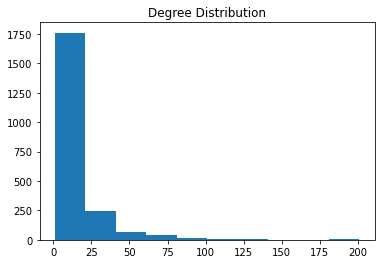

In [87]:
visualize1(G, '2008/08/15', '2008/08/16')


 ### <i> Visualization 2  - Visualize the best user! </i>
 
 Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.


In [224]:
# def visualization2(Graph, Node):
#     sub = [Node] + list(Graph.neighbors(Node))
#     H = Graph.subgraph(sub)
#     plt.figure(figsize = (10,8))
#     color_map = ['red' if node == Node else 'blue' for node in H]
#     nx.draw(H, with_labels = True, node_color=color_map, alpha = 0.7)

In [88]:
# Python3 code to demonstrate working of
# Convert date range to N equal durations
# Using loop
def equi_intervals(start_date, end_date, N):
    # initializing dates
    test_date1 = datetime.datetime.strptime(start_date, '%Y/%m/%d')
    test_date2 = datetime.datetime.strptime(end_date, '%Y/%m/%d')

    N = N
    temp = []

    # getting diff.
    diff = ( test_date2 - test_date1) // N
    for idx in range(0, N):

        # computing new dates
        temp.append((test_date1 + idx * diff))

    res = []
    for sub in temp:
        res.append(sub.strftime("%Y/%m/%d"))

    # printing result
    return res + [end_date]

In [220]:
def visualization2(Graph, Node, start_date, end_date, Metric):
    sub = [Node] + list(Graph.neighbors(Node))
    H = Graph.subgraph(sub)
    
#     plt.figure(figsize = (10,8))
    
    plt.figure(1)
    plt.title(f'Node {Node} and its neighbours')
    color_map = ['red' if node == Node else 'blue' for node in H]
    nx.draw(H, with_labels = True, node_color=color_map, alpha = 0.7)
    
    

    score = []
    intervals = equi_intervals(start_date,end_date, 5)
    for i in range(5):
        start = timestamp_conversion(intervals[i])
        end = timestamp_conversion(intervals[i+1])
        edges = [(u,v,d) for u,v,d in Graph.edges(data = True) if (start < d['timestamp'][0] < end)]
        H = nx.DiGraph()
        H.add_edges_from(edges)
#         score.append(F2_BestScore(H, Node, Metric))
        score.append(nx.closeness_centrality(H, u = Node))
    
    inn = [f'{[intervals[i],intervals[i+1]]}' for i in range(len(intervals)-1)]

    plt.figure(2)
    plt.title('Score during time')
#     plt.plot(intervals[:-1], score, marker = '.')
    plt.xticks(rotation=45, ha='right')
    plt.bar(inn, score)

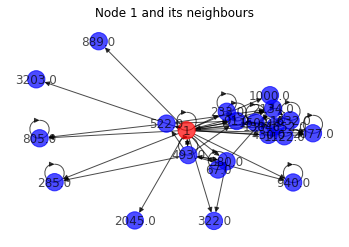

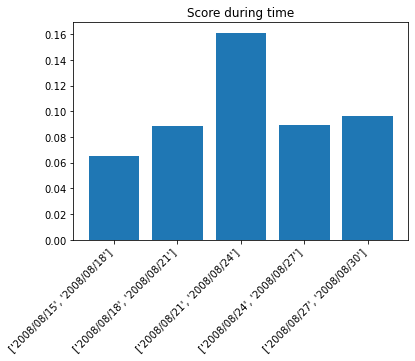

In [224]:
visualization2(G, 1, '2008/08/15', '2008/08/30', 'closeness')

 ### <i> Visualization 3 - Visualize the Shortest Ordered Route </i>

 Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.